In [3]:
from dataLoading import filepath, epoch_and_label_file

import numpy as np
import pandas as pd
import pyxdf

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
import sys
sys.path.append('/Users/sunniva/Documents/Alcohol_Detection_Project_2023-2024/')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from deepexplain.tensorflow import DeepExplain
from EEGModels import EEGNet
from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import Adam

#Sklearn imports
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GroupKFold
from sklearn.utils import compute_class_weight
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

KeyError: "Registering two gradient with name 'DeepExplainGrad'! (Previous registration was in register /opt/homebrew/lib/python3.11/site-packages/tensorflow/python/framework/registry.py:65)"

In [2]:
subject = "P009"
sessions = 2
runs = [1, 3, 4, 6]
epoch_duration = 1
channels = 16

data_arrays = {}
label_arrays = {}

i = 0
label = 'P'

for s in range(sessions):
    for r in runs:
        # if (s==0 and r==3):
        #     continue
        fname = filepath(subject, s, r, False)
        epochs_data = epoch_and_label_file(fname, epoch_duration)
        
        # Determine the label based on session and run
        if s == 0:  # Session 1
            label = 'P'  # Non-Alcohol
            label_value = 0
        elif s == 1:  # Session 2
            if r in [3, 4, 6]:
                label = 'A'  # Alcohol
                label_value = 1
            else:
                label = 'P'  # Non-Alcohol
                label_value = 0
        
        # Create a unique key for each condition and run
        data_key = f"{label}_s{s+1}_r{r}_X"
        label_key = f"{label}_s{s+1}_r{r}_Y"
        # print(epochs_data)
        num_of_epochs, _, samples = epochs_data.shape
        # print(epochs_data.shape)
        data_arrays[data_key] = np.zeros(shape=(num_of_epochs, channels, samples))
        data_arrays[data_key][:] = epochs_data[:, :channels, :]

        label_arrays[label_key] = np.full(shape=(num_of_epochs,), fill_value=label_value)
# print(label_arrays)
        
# 122 trials (epochs) - 64 channels (16) - 

Not setting metadata
313 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 250 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 250 original time points ...
0 bad epochs dropped
[[[0.27968007 0.27990144 0.27977985 ... 0.27971101 0.27951822 0.27954239]
  [0.25212887 0.25235692 0.25227171 ... 0.25224492 0.25205842 0.25205359]
  [0.48778242 0.48791304 0.48787263 ... 0.4875446  0.48744151 0.48741987]
  ...
  [0.315456   0.31553254 0.31592163 ... 0.31569034 0.31587157 0.31545815]
  [0.36026329 0.36029848 0.36058605 ... 0.36028144 0.36042726 0.36011425]
  [0.         0.         0.         ... 0.         0.         0.        ]]] 1
Using data from preloaded Raw for 313 events and 250 original time points ...
0 bad epochs dropped
Not setting metadata
316 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 eve

In [3]:
#Base 4, alc 2
# X_testing = np.vstack([data_arrays['P_s1_r4_X'], data_arrays['A_s2_r4_X']]) 
# Y_testing = np.hstack([label_arrays['P_s1_r4_Y'], label_arrays['A_s2_r4_Y']])

# #Base 6, alc 3
# X_testing = np.vstack([data_arrays['P_s1_r6_X'], data_arrays['A_s2_r6_X']]) 
# Y_testing = np.hstack([label_arrays['P_s1_r6_Y'], label_arrays['A_s2_r6_Y']])

#Base 3, alc 2
#X_testing = np.vstack([data_arrays['P_s1_r3_X'], data_arrays['A_s2_r4_X']]) 
#Y_testing = np.hstack([label_arrays['P_s1_r3_Y'], label_arrays['A_s2_r4_Y']])

#Sub P002
# X_training = ([data_arrays['P_s1_r1_X'], data_arrays['A_s2_r3_X'], data_arrays['P_s1_r4_X'], data_arrays['P_s2_r1_X'], data_arrays['A_s2_r4_X']])
# Y_training = ([label_arrays['P_s1_r1_Y'], label_arrays['A_s2_r3_Y'], label_arrays['P_s1_r4_Y'], label_arrays['P_s2_r1_Y'], label_arrays['A_s2_r4_Y']])
X_training = ([data_arrays['P_s1_r1_X'], data_arrays['A_s2_r3_X'], data_arrays['P_s1_r3_X'], data_arrays['P_s1_r4_X'], data_arrays['P_s2_r1_X'], data_arrays['A_s2_r4_X']])
Y_training = ([label_arrays['P_s1_r1_Y'], label_arrays['A_s2_r3_Y'], label_arrays['P_s1_r3_Y'], label_arrays['P_s1_r4_Y'], label_arrays['P_s2_r1_Y'], label_arrays['A_s2_r4_Y']])

print(X_training)
print(Y_training)

[array([[[0.27968007, 0.27990144, 0.27977985, ..., 0.27971101,
         0.27951822, 0.27954239],
        [0.25212887, 0.25235692, 0.25227171, ..., 0.25224492,
         0.25205842, 0.25205359],
        [0.48778242, 0.48791304, 0.48787263, ..., 0.4875446 ,
         0.48744151, 0.48741987],
        ...,
        [0.26215792, 0.26224014, 0.2624608 , ..., 0.26239467,
         0.26244971, 0.26215002],
        [0.315456  , 0.31553254, 0.31592163, ..., 0.31569034,
         0.31587157, 0.31545815],
        [0.36026329, 0.36029848, 0.36058605, ..., 0.36028144,
         0.36042726, 0.36011425]],

       [[0.27959028, 0.27983081, 0.27973238, ..., 0.27963054,
         0.27942231, 0.2794376 ],
        [0.25208667, 0.25233743, 0.2522743 , ..., 0.25221226,
         0.25201762, 0.25200537],
        [0.48744366, 0.48760781, 0.48758417, ..., 0.48725626,
         0.48714709, 0.48711678],
        ...,
        [0.26212546, 0.26220235, 0.2623975 , ..., 0.26234859,
         0.26248449, 0.26220983],
        [0.

In [4]:
groups = []

for i, run_data in enumerate(X_training):
    num_samples_in_run = run_data.shape[0]
    groups.extend([i] * num_samples_in_run)
    
groups = np.array(groups)
print(groups)

index = 0
for i in range(6):
    count = 0
    while index < len(groups) and groups[index] == i:
        count += 1
        index += 1
    print(f"{i}: {count}")



[0 0 0 ... 5 5 5]
0: 313
1: 311
2: 316
3: 318
4: 312
5: 310


In [5]:
kernels, chans, samples = 1, 16, 250

model = EEGNet(nb_classes = 1, Chans = chans, Samples = samples, 
               dropoutRate = 0.50, kernLength = 125, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),
              metrics = ['accuracy'])

[[[ 0.4239892   0.42930925  0.42647584 ...  0.42750246  0.42284793
    0.42333957]
  [-0.13222269 -0.12867595 -0.12993973 ... -0.12943214 -0.13232709
   -0.13243261]
  [ 0.98161565  0.98283241  0.98247003 ...  0.98264226  0.98170611
    0.98151196]
  ...
  [ 1.33655663  1.34166681  1.35363058 ...  1.35089756  1.3533757
    1.33615689]
  [ 1.88130018  1.88391542  1.89551061 ...  1.89167022  1.89686777
    1.88423468]
  [ 1.24387774  1.2445594   1.24935712 ...  1.24788673  1.25027801
    1.24496097]]

 [[ 0.42185752  0.42763236  0.42534886 ...  0.42558748  0.42056584
    0.42084609]
  [-0.13287776 -0.12897851 -0.12989948 ... -0.12994033 -0.13296183
   -0.1331828 ]
  [ 0.97853746  0.9800588   0.9798489  ...  0.98001774  0.97902627
    0.97875318]
  ...
  [ 1.33466649  1.33946605  1.34994749 ...  1.34821642  1.35539853
    1.33963778]
  [ 1.87690542  1.87844237  1.88824589 ...  1.88600736  1.8946866
    1.88390317]
  [ 1.23993338  1.24035416  1.24431475 ...  1.24384945  1.24767061
    1.24

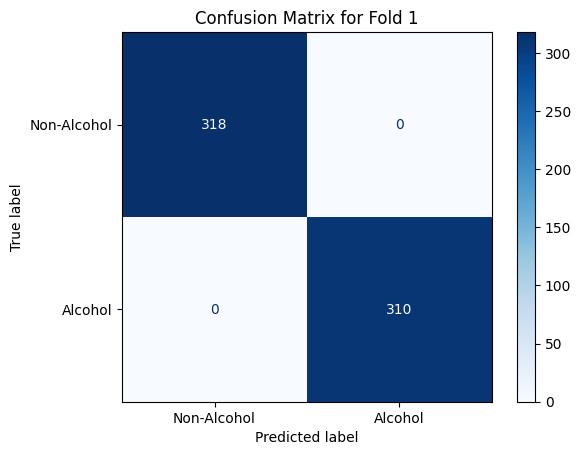

Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
[1 0 0 ... 0 0 0]
Epoch 1/15
40/40 [==============================] - 1s 31ms/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 0.0347 - val_accuracy: 1.0000
Epoch 2/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0450 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 1.0000
Epoch 3/15
40/40 [==============================] - 1s 32ms/step - loss: 0.0427 - accuracy: 1.0000 - val_loss: 0.0522 - val_accuracy: 1.0000
Epoch 4/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0401 - accuracy: 1.0000 - val_loss: 0.0626 - val_accuracy: 1.0000
Epoch 5/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0382 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 1.0000
Epoch 6/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0358 - accuracy: 1.0000 - val_loss: 0.0421 - val_accuracy: 1.0000
Epoch 7/15
40/40 [===================

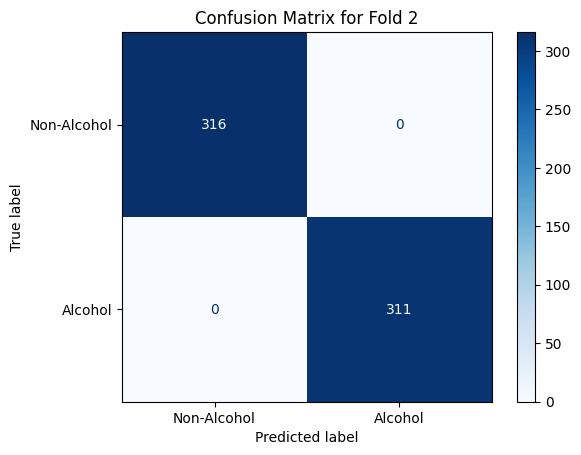

Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
[1 1 0 ... 0 0 0]
Epoch 1/15
40/40 [==============================] - 1s 32ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 2/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.0472 - val_accuracy: 1.0000
Epoch 3/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 1.0000
Epoch 4/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.0698 - val_accuracy: 1.0000
Epoch 5/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0733 - val_accuracy: 1.0000
Epoch 6/15
40/40 [==============================] - 1s 30ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.0819 - val_accuracy: 1.0000
Epoch 7/15
40/40 [===================

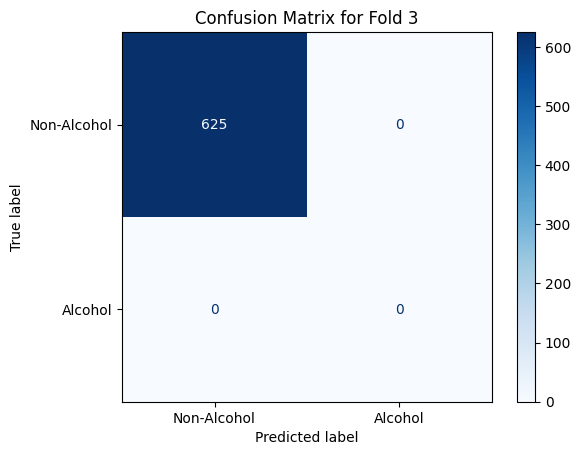

Validation Accuracy: 1.0
Validation Precision: 0.0
Validation Recall: 0.0
Validation F1 Score: 0.0
The accuracy of the model with cross validation is 1.0
The precision score of the model with cross validation is 0.6666666666666666
The recall score of the model with cross validation is 0.6666666666666666
The F1 score of the model with cross validation is 0.6666666666666666
The specificity score of the model with cross validation is 1.0
The standard deviation of the accuracy of the model with cross validation is 0.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
num_folds = 3

gkf = GroupKFold(n_splits=num_folds)

accuracy = np.zeros(num_folds)
F1_score = np.zeros(num_folds)
precision = np.zeros(num_folds)
recall = np.zeros(num_folds)
specificity = np.zeros(num_folds)

X_training = np.concatenate(X_training, axis=0)
Y_training = np.concatenate(Y_training, axis=0)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_training.reshape(X_training.shape[0], -1)).reshape(X_training.shape)

print(X_train_scaled)

for i, (train_index, val_index) in enumerate(gkf.split(X_train_scaled, Y_training, groups)):
    #Splitting the training data into training and validation
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = Y_training[train_index], Y_training[val_index]

    #Shuffling the data
    X_train_fold, y_train_fold = shuffle(X_train_fold, y_train_fold)
    X_val_fold, y_val_fold = shuffle(X_val_fold, y_val_fold)
    print(y_train_fold)

    #Reshape for the model
    X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], channels, samples, kernels)
    X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], channels, samples, kernels)

    #Train the model
    fittedModel = model.fit(X_train_fold, y_train_fold, batch_size = 32, epochs = 15, validation_data=(X_val_fold, y_val_fold))
    
    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold)
    print(f'Score for fold: {scores}')

    # Predictions and metrics
    y_pred_fold = model.predict(X_val_fold)
    y_pred_fold = np.where(y_pred_fold > 0.5, 1, 0)

    # #Plotting confusion matrix
    labels = ["Non-Alcohol", "Alcohol"]
    cm = confusion_matrix(y_val_fold, y_pred_fold, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    # Assign metrics to numpy array for the current fold
    accuracy[i] = accuracy_score(y_val_fold, y_pred_fold)
    F1_score[i] = f1_score(y_val_fold, y_pred_fold)
    precision[i] = precision_score(y_val_fold, y_pred_fold)
    recall[i] = recall_score(y_val_fold, y_pred_fold)
    specificity[i] = tn / (tn + fp)

    # Print metrics
    print(f"Validation Accuracy: {accuracy[i]}")
    print(f"Validation Precision: {precision[i]}")
    print(f"Validation Recall: {recall[i]}")
    print(f"Validation F1 Score: {F1_score[i]}")

    #How many occurances appear in the train set
    unique_train, counts_train = np.unique(y_train_fold, return_counts=True)
    unique_test, counts_test = np.unique(y_val_fold, return_counts=True)


standard_deviation = np.std(accuracy)

print("The accuracy of the model with cross validation is", accuracy.mean())
print("The precision score of the model with cross validation is", precision.mean())
print("The recall score of the model with cross validation is", recall.mean())
print("The F1 score of the model with cross validation is", F1_score.mean())
print("The specificity score of the model with cross validation is", specificity.mean())
print("The standard deviation of the accuracy of the model with cross validation is", standard_deviation)

In [7]:
for s in range(sessions):
    for r in runs:
        # if (s==0 and r==3):
        #     continue
        fname = filepath(subject, s, r, True)
        epochs_data = epoch_and_label_file(fname, epoch_duration)

        # Determine the label based on session and run
        if s == 0:  # Session 1
            label = 'P'  # Non-Alcohol
            label_value = 0
        elif s == 1:  # Session 2
            if r in [3, 4, 6]:
                label = 'A'  # Alcohol
                label_value = 1
            else:
                label = 'P'  # Non-Alcohol
                label_value = 0
        
        # Create a unique key for each condition and run
        data_key = f"{label}_s{s+1}_r{r}_X"
        label_key = f"{label}_s{s+1}_r{r}_Y"

        num_of_epochs, _, samples = epochs_data.shape
        print(epochs_data.shape)
        data_arrays[data_key] = np.zeros(shape=(num_of_epochs, channels, samples))
        data_arrays[data_key][:] = epochs_data[:, :channels, :]

        label_arrays[label_key] = np.full(shape=(num_of_epochs,), fill_value=label_value)
print(label_arrays)

Not setting metadata
313 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 250 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 1 events and 250 original time points ...
1 bad epochs dropped
[] 0
Using data from preloaded Raw for 313 events and 250 original time points ...
92 bad epochs dropped
(221, 17, 250)
Not setting metadata
316 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 250 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 1 events and 250 original time points ...
1 bad epochs dropped
[] 0
Using data from preloaded Raw for 316 events and 250 original time points ...
216 bad epochs dropped
(100, 17, 250)
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 250

In [8]:
#Base 6, alc 3
X_testing = np.vstack([data_arrays['P_s1_r6_X'], data_arrays['A_s2_r6_X']]) 
Y_testing = np.hstack([label_arrays['P_s1_r6_Y'], label_arrays['A_s2_r6_Y']])

Epoch 1/15
118/118 [==============================] - 2s 18ms/step - loss: 0.0160 - accuracy: 1.0000
Epoch 2/15
118/118 [==============================] - 2s 17ms/step - loss: 0.0132 - accuracy: 1.0000
Epoch 3/15
118/118 [==============================] - 2s 18ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 4/15
118/118 [==============================] - 2s 19ms/step - loss: 0.0108 - accuracy: 1.0000
Epoch 5/15
118/118 [==============================] - 2s 17ms/step - loss: 0.0098 - accuracy: 1.0000
Epoch 6/15
118/118 [==============================] - 2s 17ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 7/15
118/118 [==============================] - 2s 17ms/step - loss: 0.0086 - accuracy: 1.0000
Epoch 8/15
118/118 [==============================] - 2s 17ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 9/15
118/118 [==============================] - 2s 17ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 10/15
118/118 [==============================] - 2s 17ms/step - loss: 0.0068 - accura

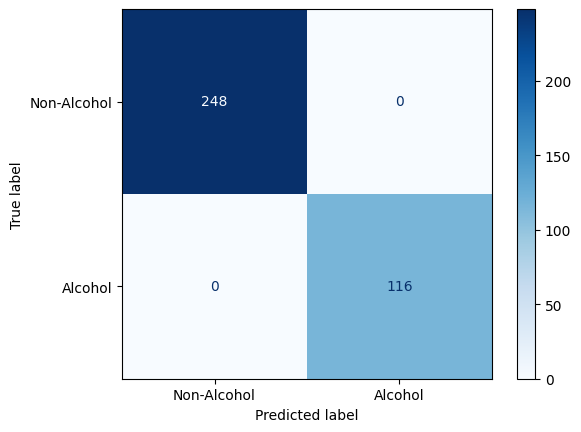

The accuracy of the model with cross validation is 1.0
The precision score of the model with cross validation is 1.0
The recall score of the model with cross validation is 1.0
The F1 score of the model with cross validation is 1.0
The specificity score of the model with cross validation is 1.0


In [9]:
X_test_scaled = scaler.transform(X_testing.reshape(X_testing.shape[0], -1)).reshape(X_testing.shape)
X_train_scaled, Y_training = shuffle(X_train_scaled, Y_training)
X_test_scaled, Y_testing = shuffle(X_test_scaled, Y_testing)

# Reshape the training data to include the channel dimension
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], chans, samples, kernels)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], chans, samples, kernels)

fittedModel = model.fit(X_train_scaled, Y_training, batch_size = 16, epochs = 15)

pred_val = model.predict(X_test_scaled)
pred_val = np.where(pred_val > 0.5, 1, 0)

labels = ["Non-Alcohol", "Alcohol"]
cm = confusion_matrix(Y_testing, pred_val, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Save the plot to a file
plt.savefig(f'cm_{subject}_final.png', dpi=300)  # Saves the confusion matrix plot as a PNG file with 300 DPI
plt.show()  # Show the plot as well

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_true=Y_testing, y_pred=pred_val)
F1_score = f1_score(y_true=Y_testing, y_pred=pred_val)
precision= precision_score(y_true=Y_testing, y_pred=pred_val)
recall = recall_score(y_true=Y_testing, y_pred=pred_val)
specificity = tn/(tn+fp)

print("The accuracy of the model with cross validation is", accuracy)
print("The precision score of the model with cross validation is", precision)
print("The recall score of the model with cross validation is", recall)
print("The F1 score of the model with cross validation is", F1_score)
print("The specificity score of the model with cross validation is", specificity)

In [10]:
# # Specify the file path
# data_file_path = "resampled_data.npy"
# label_file_path = "labels.npy"

# # Load the NumPy file
# resampled_data_array = np.load(data_file_path, allow_pickle=True).item()
# label_array = np.load(label_file_path, allow_pickle=True).item()

# X_testing = np.vstack(list(resampled_data_array.values())) 
# Y_testing = np.hstack(list(label_array.values()))

# X_test_scaled = scaler.transform(X_testing.reshape(X_testing.shape[0], -1)).reshape(X_testing.shape)
# X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], chans, samples, kernels)
# X_test_scaled, Y_testing = shuffle(X_test_scaled, Y_testing)

# # Predict using the fitted model
# pred_val = model.predict(X_test_scaled)
# pred_val = np.where(pred_val > 0.5, 1, 0)

# # Evaluate the predictions
# labels = ["Non-Alcohol", "Alcohol"]
# cm = confusion_matrix(Y_testing, pred_val, labels=[0, 1])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues)

# # Save the plot to a file
# plt.savefig(f'cm_{subject}_alcoholic_test.png', dpi=300)  # Saves the confusion matrix plot as a PNG file with 300 DPI
# plt.show()  # Show the plot as well

# tn, fp, fn, tp = cm.ravel()

# accuracy = accuracy_score(y_true=Y_testing, y_pred=pred_val)
# F1_score = f1_score(y_true=Y_testing, y_pred=pred_val)
# precision = precision_score(y_true=Y_testing, y_pred=pred_val)
# recall = recall_score(y_true=Y_testing, y_pred=pred_val)
# specificity = tn / (tn + fp)

# print("The accuracy of the model with cross validation is", accuracy)
# print("The precision score of the model with cross validation is", precision)
# print("The recall score of the model with cross validation is", recall)
# print("The F1 score of the model with cross validation is", F1_score)
# print("The specificity score of the model with cross validation is", specificity)


In [13]:
with DeepExplain(session = K.get_session()) as de:
	input_tensor   = model.layers[0].input
	fModel         = Model(inputs = input_tensor, outputs = model.layers[-2].output)    
	target_tensor  = fModel(input_tensor)    

	# can use epsilon-LRP as well if you like.
	attributions   = de.explain('deeplift', target_tensor * Y_testing, input_tensor, X_testing)
	# attributions = de.explain('elrp', target_tensor * Y_test, input_tensor, X_test)

KeyError: "Registering two gradient with name 'DeepExplainGrad'! (Previous registration was in register /opt/homebrew/lib/python3.11/site-packages/tensorflow/python/framework/registry.py:65)"